<a href="https://colab.research.google.com/github/ciepielajan/Multi-Class-Classification-NLP/blob/main/Detecting_intentions_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detecting_intentions_MLP

#### Pobranie danych

In [1]:
# https://drive.google.com/file/d/1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq/view?usp=sharing
!gdown --id "1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq"

Downloading...
From: https://drive.google.com/uc?id=1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq
To: /content/user_intent.zip
100% 271k/271k [00:00<00:00, 8.77MB/s]


In [2]:
!unzip "user_intent.zip"

Archive:  user_intent.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: validation.csv          


In [3]:
import pandas as pd
import numpy as np

data_set_train = pd.read_csv("train.csv")
data_set_valid = pd.read_csv("validation.csv")

print(data_set_train.shape)
print(data_set_valid.shape)

print(data_set_train.columns)
print(data_set_valid.columns)

(13784, 2)
(700, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


#### Podstawowy process text

In [4]:
import re
def process_text(sentence):
    sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()
    
    return sentence

In [5]:
data_set_train["clean_text"] = data_set_train["text"].apply(lambda x: process_text(x))

#### `LabelEncoder` oraz `to_categorical`

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 


labelencoder = LabelEncoder()
labelencoder.fit(data_set_train["label"])

data_set_train["labelencoder"] = labelencoder.transform(data_set_train["label"])

dummy_y = to_categorical(data_set_train["labelencoder"], dtype ="float32")

data_set_train[["clean_text","label","labelencoder"]].head(5)

,clean_text,label,labelencoder
0,find cinema nearest for films,SearchScreeningEvent,6
1,give the current series two stars,RateBook,4
2,find the good girl at movie house,SearchScreeningEvent,6
3,please make reservations for three at kosher t...,BookRestaurant,1
4,what is the forecast for here one second from now,GetWeather,2


In [7]:
dummy_y.shape

(13784, 7)

In [8]:
id_intention = 4
print("Sprawdzenie poprawności LabelEncoder i to_categorical \n")
print("Label - ", data_set_train["label"].iloc[id_intention])
print("LabelEncoder - ", data_set_train["labelencoder"].iloc[id_intention])
print()
print("to_categorical - ", dummy_y[id_intention])
print()
print("return to LabelEncoder - ",np.argmax(dummy_y[id_intention], axis=-1))
print("return to Label - ",labelencoder.inverse_transform([np.argmax(dummy_y[id_intention], axis=-1)]))

Sprawdzenie poprawności LabelEncoder i to_categorical 

Label -  GetWeather
LabelEncoder -  2

to_categorical -  [0. 0. 1. 0. 0. 0. 0.]

return to LabelEncoder -  2
return to Label -  ['GetWeather']


#### Zdefiniowanie X i y

In [9]:
X = data_set_train["clean_text"]
y = dummy_y

In [10]:
X.shape, y.shape

((13784,), (13784, 7))

#### Podział zbioru 

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11027,), (2757,), (11027, 7), (2757, 7))

#### `Tokenizer` i `pad_sequences`

In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 7
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)

#### Model

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, SimpleRNN, Dense
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))  
model.add(Flatten())
model.add(Dense(7, activation="softmax")) # sigmoid / softmax
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            976800    
_________________________________________________________________
flatten (Flatten)            (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 4907      
Total params: 981,707
Trainable params: 981,707
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks = [EarlyStop] )
scores = model.evaluate(X_test, y_test)
print(f"Accuracy {scores[1] * 100}")

Epoch 1/20
138/138 [==============================] - 4s 21ms/step - loss: 1.5900 - accuracy: 0.6860 - val_loss: 0.3944 - val_accuracy: 0.9347
Epoch 2/20
138/138 [==============================] - 2s 18ms/step - loss: 0.2751 - accuracy: 0.9534 - val_loss: 0.1586 - val_accuracy: 0.9642
Epoch 3/20
138/138 [==============================] - 2s 16ms/step - loss: 0.1098 - accuracy: 0.9808 - val_loss: 0.1118 - val_accuracy: 0.9719
Epoch 4/20
138/138 [==============================] - 2s 16ms/step - loss: 0.0662 - accuracy: 0.9890 - val_loss: 0.0926 - val_accuracy: 0.9746
Epoch 5/20
138/138 [==============================] - 2s 17ms/step - loss: 0.0409 - accuracy: 0.9943 - val_loss: 0.0836 - val_accuracy: 0.9760
Epoch 6/20
138/138 [==============================] - 2s 16ms/step - loss: 0.0284 - accuracy: 0.9954 - val_loss: 0.0775 - val_accuracy: 0.9760
Epoch 7/20
138/138 [==============================] - 2s 16ms/step - loss: 0.0200 - accuracy: 0.9976 - val_loss: 0.0739 - val_accuracy: 0.9764

#### save all files for develop

In [18]:
import pickle
from keras.models import load_model
from datetime import datetime 

In [19]:
now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [20]:
#save and del model 
model.save(f'MLP_develop_model_{now}.h5')  

In [21]:
MLP_develop = {
    "tokenizer" :  tokenizer ,
    "maxlen" :  maxlen ,
    "labelencoder" :  labelencoder 
}

In [22]:
pickle.dump(MLP_develop, open(f"MLP_develop_config_{now}.pickle", "wb"))

#### Predykcja na zbiorze validacyjnym

In [23]:
# oczysczenie danych
data_set_valid["clean_text"] = data_set_valid["text"].apply(lambda x: process_text(x))

# labelencoder 
data_set_valid["labelencoder"] = labelencoder.fit_transform(data_set_valid["label"])

# tokenizacja weg przetrenowanego już tokenizera
X_validate = tokenizer.texts_to_sequences(data_set_valid["clean_text"])

# pad sequel
X_validate = pad_sequences(X_validate, padding="post", truncating="post", maxlen=maxlen)
X_validate

array([[  15,   42,   50, ...,   44,    6,    1],
       [ 241,  177,   21, ..., 1593,    3,  738],
       [  15,    8,    1, ...,   36,    4,   48],
       ...,
       [  28,    1,   84, ...,   38,    0,    0],
       [  15,    8,    1, ...,   36,    4, 2688],
       [  45,   40,    4, ...,  152,  129,  404]], dtype=int32)

In [24]:
dummy_y_valid = data_set_valid["labelencoder"].values
dummy_y_valid[:5]

array([6, 3, 2, 0, 6])

In [25]:
# Sprawdzenie rozmiaru zbiorów validacyjnego
X_validate.shape, dummy_y_valid.shape

((700, 7), (700,))

In [26]:
predicted_lstm_val = np.argmax(model.predict(X_validate), axis=-1)
predicted_lstm_val[:5]

array([6, 3, 2, 0, 6])

#### Rozkodowanie przewidzianych i prawidłowych etykiet

In [27]:
y_pred = labelencoder.inverse_transform(predicted_lstm_val)
y_pred = pd.Series(y_pred)
y_pred.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [28]:
y_val = labelencoder.inverse_transform(dummy_y_valid)
y_val = pd.Series(y_val)
y_val.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

#### `Confusion matrix`

In [29]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.98
F1_score: 0.98
                      precision    recall  f1-score   support

       AddToPlaylist       0.98      0.99      0.99       100
      BookRestaurant       0.99      0.98      0.98       100
          GetWeather       0.96      0.98      0.97       100
           PlayMusic       1.00      0.97      0.98       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.92      1.00      0.96       100
SearchScreeningEvent       1.00      0.92      0.96       100

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

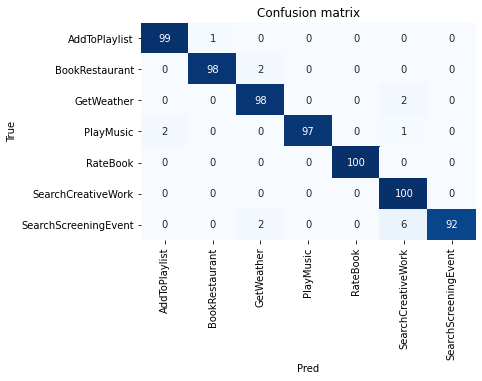

In [30]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, y_pred),2))
print('F1_score:', round(f1_score(y_val, y_pred, average='weighted'),2))

print(classification_report(y_val, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Zapoznanie się z błędnymi predykcjami 

In [42]:
# pobranie indexów błędnie przewidzianych etykiet 
indexes = []
for i, phrase in enumerate(y_pred):
  if phrase != y_val[i]:                                      #  Wszysktie błędne predykcje
    # if phrase == 'SearchCreativeWork':            #  konkretna klasa 1
    #   if y_val[i] == 'SearchScreeningEvent':      #  konkretna klasa 2
        indexes.append(i)
print(indexes)

[6, 240, 252, 336, 378, 451, 481, 483, 499, 519, 557, 567, 615, 648, 671, 689]


In [43]:
# ustadaryzowanie obliczonego prawdopodobieństwa dla wystapienia danej etykiety 
import warnings
warnings.filterwarnings('ignore')

y_proba = [      [  round(j*100, 4) for j in i  ]       for i in model.predict_proba(X_validate)    ]
y_proba[:2]

[[0.0, 0.0001, 0.0001, 0.0, 0.0, 0.0, 99.9997],
 [0.0667, 0.0411, 0.0026, 99.8756, 0.0086, 0.0039, 0.0016]]

In [44]:
for i in indexes:
  print(f"----------------------------\nTekst komendy id {i}:\n{data_set_valid['text'][i]}\n")
  print(f"Oczyszczona komenda i skrócona do wartości maxlen={maxlen}:\n{' '.join(data_set_valid['clean_text'][i].split()[:maxlen])}\n")
  print(f'True category: {y_val[i]} - probability - {y_proba[i][labelencoder.transform([y_val[i]])[0]]}%')
  print(f'Predicted category: {y_pred[i]} - probability - {y_proba[i][labelencoder.transform([y_pred[i]])[0]]}%')
  print("\n")

----------------------------
Tekst komendy id 6:
I want to see While the Sun Shines at the closest movie house.

Oczyszczona komenda i skrócona do wartości maxlen=7:
want to see while the sun shines

True category: SearchScreeningEvent - probability - 28.5087%
Predicted category: SearchCreativeWork - probability - 58.709%


----------------------------
Tekst komendy id 240:
I want to know if there are any movies playing in the area.

Oczyszczona komenda i skrócona do wartości maxlen=7:
want to know if there are any

True category: SearchScreeningEvent - probability - 2.4796%
Predicted category: GetWeather - probability - 79.0004%


----------------------------
Tekst komendy id 252:
can you put on Like A Hurricane by Paul Landers

Oczyszczona komenda i skrócona do wartości maxlen=7:
can you put on like hurricane by

True category: PlayMusic - probability - 3.8386%
Predicted category: AddToPlaylist - probability - 95.9741%


----------------------------
Tekst komendy id 336:
I'd like for

Wnioski:
> Model ma tendencję do faworyzowania etykiety SearchCreativeWork kosztem SearchScreeningEvent. Świadczy o tym `100% skutczeność predykcji SearchCreativeWork` przy `91% skuteczności predykcji SearchScreeningEvent`. Może to wynikać z przeuczenia modelu. 

> Błędne predykcje zawieraja takie słowa jak `want` i `see` może lemmatyzacja lub usunięcie stop wrordów poprawi wynik. 